# Notebook to debug Hyper Parameter Optimization

In [9]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms

import argparse

TRAIN ='train'
VALIDATION = 'val'

MAX_SAMPLES_PROPORTION = 0.2
THESHOLD_LOGGING_SAMPLES = 20

def log_metrics(loss, running_corrects, running_samples, total_samples):
    accuracy = running_corrects / running_samples
    print("Images [{}/{} ({:.0f}%)] Loss: {:.3f} Accuracy: {}/{} ({:.3f}%)".format(
        running_samples,
        total_samples,
        100.0 * (running_samples / total_samples),
        loss.item(),
        running_corrects,
        running_samples,
        100.0 * accuracy,
        )
    )
    
def test(model, test_loader, criterion):
    print("Testing Model on Whole Testing Dataset")
    model.eval()
    running_loss = 0
    running_corrects = 0
    running_samples = 0
    total_samples = len(test_loader.dataset)

    for inputs, labels in test_loader:
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data).item()
        running_samples += len(inputs)
        
        #NOTE: Comment lines below to train and test on whole dataset
        if running_samples > (MAX_SAMPLES_PROPORTION * total_samples):
            break

    total_loss = running_loss / len(test_loader.dataset)
    total_acc = running_corrects / len(test_loader.dataset)
    print(f"Testing Accuracy: {100*total_acc:.3f}, Testing Loss: {total_loss:.3f}")


def validate(model, validation_loader, criterion):
    model.eval()
    running_loss = 0
    running_corrects = 0
    running_samples = 0
    total_samples = len(validation_loader.dataset)

    for inputs, labels in validation_loader:
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data).item()
        running_samples += len(inputs)
        if running_samples % THESHOLD_LOGGING_SAMPLES == 0:
            log_metrics(loss, running_corrects, running_samples, total_samples)
            
        #NOTE: Comment lines below to train and test on whole dataset
        if running_samples > (MAX_SAMPLES_PROPORTION * total_samples):
            break

    epoch_loss = running_loss / running_samples
    epoch_acc = running_corrects / running_samples
    print(f"Phase validation, Epoc loss {epoch_loss:.3f}, Epoc accuracy {100*epoch_acc:.3f}")
    return epoch_loss


def train(model, train_loader, criterion, optimizer):
    model.train()

    running_loss = 0.0
    running_corrects = 0
    running_samples = 0
    total_samples = len(train_loader.dataset)

    for inputs, labels in train_loader:
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data).item()
        running_samples += len(inputs)
        if running_samples % THESHOLD_LOGGING_SAMPLES == 0:
            log_metrics(loss, running_corrects, running_samples, total_samples)

        #NOTE: Comment lines below to train and test on whole dataset
        if running_samples > (MAX_SAMPLES_PROPORTION * total_samples ):
            break

    epoch_loss = running_loss / running_samples
    epoch_acc = running_corrects / running_samples
    print(f"Phase training, Epoc loss {epoch_loss:.3f}, Epoc accuracy {100*epoch_acc:.3f}")
    return epoch_loss

def train_with_early_stopping(model, datasets_loader, epochs, loss_criterion, optimizer):
    best_loss = 1e6
    print(f"Training Model on {MAX_SAMPLES_PROPORTION*100}% of the Dataset")
    
    for epoch in range(1, epochs + 1):
        print(f"Epoch {epoch} ...")
        _ = train(model, datasets_loader[TRAIN], loss_criterion, optimizer)
        validate_epoch_loss = validate(model, datasets_loader[VALIDATION], loss_criterion)
        print(validate_epoch_loss, best_loss)
        if validate_epoch_loss < best_loss:
            best_loss = validate_epoch_loss
        else:
            print('Loss of validation model started to increase')
            break

def net(num_classes: int):
    '''Initializes a pretrained model'''
    model = models.resnet50(pretrained=True)

    # Freeze training of the convolutional layers
    for param in model.parameters():
        param.requires_grad = False   

    # Override the last layer to adjust it to our problem
    num_features=model.fc.in_features
    model.fc = nn.Sequential(
        nn.Linear(num_features, 1024),
        nn.ReLU(inplace=True),
        nn.Linear(1024, num_classes)
    )
    
    return model


def create_data_loaders(train_data_dir: str, valid_data_dir: str, batch_size: int):
    '''Create pytorch data loaders'''
     
    data_dir = { TRAIN: train_data_dir, VALIDATION: valid_data_dir}
    
        
    data_transforms = {
        TRAIN: transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        VALIDATION: transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
    }
   
    #     transform_steps = [ 
    #         transforms.Resize((224,224)),
    #         transforms.CenterCrop(224),
    #         transforms.ToTensor(),
    #         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]

    #     data_transforms = {
    #         TRAIN: transforms.Compose([ transforms.RandomHorizontalFlip(), *transform_steps]),
    #         VALIDATION: transforms.Compose(transform_steps)
    #     }

    image_datasets = {}
    dataloaders = {}
    for x in [TRAIN, VALIDATION]:
        
        image_datasets[x] = torchvision.datasets.ImageFolder(data_dir[x], data_transforms[x])
        dataloaders[x] = torch.utils.data.DataLoader(
            image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=2)
        
    return dataloaders

def get_num_classes(dataloader) -> int:
        return len(dataloader[TRAIN].dataset.classes)
    
def save_model(model, model_dir):
    path = os.path.join(model_dir, "model.pth")
    print(f"Saving the model to path {path}")
    torch.save(model.state_dict(), path)

def main(args):
    
    from PIL import ImageFile
    ImageFile.LOAD_TRUNCATED_IMAGES = True
    
    dataset_loaders = create_data_loaders(args.data_dir_train, args.data_dir_validation, args.batch_size)
    
    num_classes = get_num_classes(dataset_loaders)
    model=net(num_classes)
    loss_criterion = nn.CrossEntropyLoss()
    optimizer =  optim.Adam(model.fc.parameters(), lr=args.lr)
    
    train_with_early_stopping(model, dataset_loaders, args.epochs, loss_criterion, optimizer)
    save_model(model, args.model_dir)

# def model_fn(model_dir):
#     model = Net()
#     with open(os.path.join(model_dir, "model.pth"), "rb") as f:
#         model.load_state_dict(torch.load(f))
#     return model


if __name__=='__main__':
    parser=argparse.ArgumentParser(description="Training Job for Hyperparameter tuning")
    
    parser.add_argument(
        "--batch-size",
        type=int,
        default=64,
        metavar="N",
        help="input batch size for training (default: 64)",
    )

    parser.add_argument(
        "--epochs",
        type=int,
        default=14,
        metavar="N",
        help="number of epochs to train (default: 14)",
    )
    parser.add_argument(
        "--lr", type=float, default=1.0, metavar="LR", help="learning rate (default: 1.0)"
    )

    
    # Container environment
#     parser.add_argument("--hosts", type=list, default=json.loads(os.environ["SM_HOSTS"]))
#     parser.add_argument("--current-host", type=str, default=os.environ["SM_CURRENT_HOST"])
    parser.add_argument("--model-dir", type=str, default=os.environ["SM_MODEL_DIR"])
    parser.add_argument("--data-dir-train", type=str, default=os.environ["SM_CHANNEL_TRAINING"])
    #parser.add_argument("--data-dir-test", type=str, default=os.environ["SM_CHANNEL_TESTING"])
    parser.add_argument("--data-dir-validation", type=str, default=os.environ["SM_CHANNEL_VALIDATION"])
#     parser.add_argument("--num-gpus", type=int, default=os.environ["SM_NUM_GPUS"])
    
    args = parser.parse_args()
    
    #     from PIL import ImageFile
    #     ImageFile.LOAD_TRUNCATED_IMAGES = True
    #     dataset_loaders = create_data_loaders(args.data_dir_train, args.data_dir_validation, args.batch_size)


    #     for data in dataset_loaders[TRAIN]:
    #         pass
    #     print("ok")
        
    main(args)

Epoch 1 ...
Images [160/6680 (2%)] Loss: 5.114 Accuracy: 4/160 (2.500%)
Images [320/6680 (5%)] Loss: 5.222 Accuracy: 10/320 (3.125%)
Images [480/6680 (7%)] Loss: 4.713 Accuracy: 19/480 (3.958%)
Images [640/6680 (10%)] Loss: 4.613 Accuracy: 41/640 (6.406%)
Images [800/6680 (12%)] Loss: 4.477 Accuracy: 65/800 (8.125%)
Images [960/6680 (14%)] Loss: 4.249 Accuracy: 92/960 (9.583%)
Images [1120/6680 (17%)] Loss: 4.098 Accuracy: 125/1120 (11.161%)
Images [1280/6680 (19%)] Loss: 3.767 Accuracy: 162/1280 (12.656%)
Phase training, Epoc loss 4.479, Epoc accuracy 13.616
Images [160/835 (19%)] Loss: 3.505 Accuracy: 47/160 (29.375%)
Phase validation, Epoc loss 3.503, Epoc accuracy 31.250
3.503211816151937 1000000.0
Epoch 2 ...
Images [160/6680 (2%)] Loss: 3.506 Accuracy: 48/160 (30.000%)
Images [320/6680 (5%)] Loss: 2.920 Accuracy: 106/320 (33.125%)
Images [480/6680 (7%)] Loss: 3.004 Accuracy: 168/480 (35.000%)
Images [640/6680 (10%)] Loss: 2.330 Accuracy: 235/640 (36.719%)
Images [800/6680 (12%)] 

In [22]:
! rm -r /opt/ml/output/tensors

In [24]:
! ls /opt/ml/model

config	input  model.pth


## TEST

### Arguments

In [4]:
import sys
import os

sys.argv = ["hpo.py", "--batch-size", "32", "--lr", "0.001"]

os.environ['SM_CHANNEL_TRAINING'] = "../project-files/dogImages/train"
os.environ['SM_CHANNEL_VALIDATION'] = "../project-files/dogImages/valid"
#os.environ['SM_CHANNEL_TESTING'] = "../project-files/dogImages/test"
os.environ['SM_MODEL_DIR'] = "/opt/ml/model"

! mkdir /opt/ml/model
! chown -R ec2-user:ec2-user /opt/ml/model # give ownership to the current EC2 user

chown: invalid user: ‘ec2-user:ec2-user’


### Data loaders

In [36]:
%matplotlib inline

import matplotlib.pyplot as plt

data_loaders = create_data_loaders("./dogImages/test", "./dogImages/test", 30)

In [37]:
data_loaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x7fa02ae8e898>,
 'val': <torch.utils.data.dataloader.DataLoader at 0x7fa02ae8e908>}

Checking one batch:

In [39]:
batch = next(iter(data_loaders['train']))

In [40]:
batch[0].shape,  batch[1].shape

(torch.Size([30, 3, 224, 224]), torch.Size([30]))

This batch contains 30 images, with 3 channels, and each image is of size 224 by 224. There are 30 labels associated to each image.

Checking one image (and the transformation):

In [41]:
batch[0][0].shape, batch[0][0].permute(1, 2, 0).shape

(torch.Size([3, 224, 224]), torch.Size([224, 224, 3]))

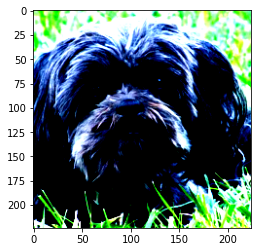

In [42]:
image = batch[0][0].permute(1, 2, 0)
breed = batch[1][0]

plt.imshow(image);

In [53]:
breed

tensor(37)

In [54]:
!ls ./dogImages/test/0{breed + 1}.*

Brussels_griffon_02656.jpg  Brussels_griffon_02701.jpg
Brussels_griffon_02667.jpg  Brussels_griffon_02707.jpg
Brussels_griffon_02678.jpg  Brussels_griffon_02716.jpg
Brussels_griffon_02699.jpg


### Base Model 

In [57]:
num_classes =len( data_loaders['train'].dataset.classes)
num_classes

133

In [58]:
model = net(num_classes) #If it complain, specify the weights based on the official documentation
type(model)

torchvision.models.resnet.ResNet

In [60]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### Produced model

In [28]:
num_classes = get_num_classes(dataset_loaders)
num_classes

133

In [33]:
def model_fn(model_dir):
    model = net(133)
    with open(os.path.join(model_dir, "model.pth"), "rb") as f:
        model.load_state_dict(torch.load(f))
    return model
the_model = model_fn("/opt/ml/model")

In [45]:
the_model.eval()
with torch.no_grad():
    inputs, labels = batch
    prediction = the_model(inputs)
    

In [49]:
inputs.shape, labels.shape

(torch.Size([30, 3, 224, 224]), torch.Size([30]))

In [47]:
prediction.shape

torch.Size([30, 133])

In [52]:
prediction[0]

torch.Size([133])

In [56]:
_, preds = torch.max(prediction, 1)
preds

tensor([  0,  23,  61,  13, 123,  50,  95, 109, 116,  43,  10,  63,  96,  11,
         44,  76,   4,  71,  13, 112,  78,  19,  89, 108,  66,  87,  16,  50,
         68, 101])

In [57]:
labels

tensor([  0,  23,  61,  13,   8,  50,  95, 109,  90, 102,  10,  63,  96,  72,
         44,  76,   4, 121,  13, 112,  78,  19, 131, 108, 107,  87,  16,  50,
         68,  58])

In [61]:
torch.sum(preds == labels.data)

tensor(22)

In [58]:
torch.sum(preds == labels.data).item()

22

In [59]:
torch.sum(preds == labels.data).item() / len(labels)

0.7333333333333333

### Test code with estimator

In [2]:
from sagemaker.pytorch import PyTorch

import sagemaker

session = sagemaker.Session()

bucket_sagemaker = session.default_bucket()
print("Default Bucket: {}".format(bucket_sagemaker))

region = session.boto_region_name
print("AWS Region: {}".format(region))

role = sagemaker.get_execution_role()
print("RoleArn: {}".format(role))

BUCKET_DATA_PATH = f"s3://{bucket_sagemaker}/dogImages"
BUCKET_DATA_PATH

hyperparameters = {'batch-size':"32", 'lr':"0.001"}

estimator = PyTorch(
    entry_point="hpo.py",
    base_job_name="final-training-job2222",
    role=role,
    py_version='py36',
    framework_version="1.8",
    hyperparameters=hyperparameters,
    instance_count=1,
    instance_type="ml.m5.large"
)

inputs_mapping = {
    "training": f"{BUCKET_DATA_PATH}/train", 
    "validation":f"{BUCKET_DATA_PATH}/valid", 
    "testing":f"{BUCKET_DATA_PATH}/test"
}

estimator.fit(wait=True, inputs=inputs_mapping)


Default Bucket: sagemaker-us-east-1-401658568889
AWS Region: us-east-1
RoleArn: arn:aws:iam::401658568889:role/service-role/AmazonSageMaker-ExecutionRole-20230212T121090
2023-02-27 19:38:55 Starting - Starting the training job...
2023-02-27 19:39:22 Starting - Preparing the instances for trainingProfilerReport-1677526734: InProgress
......
2023-02-27 19:40:22 Downloading - Downloading input data.........
2023-02-27 19:41:43 Training - Downloading the training image...
2023-02-27 19:42:23 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-02-27 19:42:08,308 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-02-27 19:42:08,311 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-02-27 19:42:08,320 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups su